In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed

In [2]:
from dataset import read_dataset, divide_dataset, balance_dataset

# Classical SVM with Quantum Kernel

We follow here this paper https://arxiv.org/pdf/1804.11326.pdf that describes how to use quantum feature maps, i.e. a specific way to encode classical data in a small quantum circuit, to compute kernel that would be otherwise difficult to compute classicaly. 


## Kernel methods
Kernel methods, such as SVM, use a kernel $K(x_i,x_j)$ between two data points. The data points are usually first transformed in a higher dimensional space through an emdedding function $\phi$ that makes the dataset easier to separate. The kernel is therefore given by :

$$
K(x_i,x_j) = \langle \phi(x_i), \phi(x_j) \rangle
$$

While the embedding are sometimes expensive the compute, the kernel can remain relatively cheap to evaluate.

## Quantum kernel

The method presented here propose to create complicated embeddings through quantum feature maps : $|\phi(x_i)\rangle = U_{\phi}(x_i)|0\rangle and to compute the kernel via :

$$
 \langle \phi(x_i), \phi(x_j) \rangle = \langle 0| U^{\dagger}_{\phi}(x_i) U_\phi(x_j)|0\rangle
$$

i.e. by starting with all qbits in $|0\rangle$, then applying the quantum feature map with point $x_j$, then applying the conjugate of the quantum feature map using point $x_i$ and then measuring to see how far we are from the initial state $|0\rangle$. For example if the two points are identical the system will return exactly to $|0\rangle$. 

The quantum advantage of this methods only rely on the possibility to express feature maps that would be expensive to compute classicaly but that are cheap to obtain on a quantum chip. There is no use of quantum parallelism.

# Data

As usual we use the HTRU2 data for pulsar. We load it and extract a small subset of the data here.

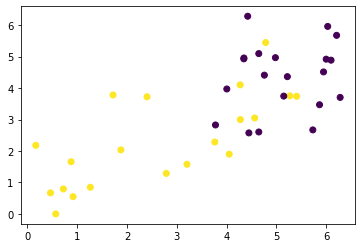

In [24]:
# read the data
dataset = read_dataset()

# extract a balances subset containing a limited number of points
npts = 50
dataset = balance_dataset(dataset, npts)

# only consider a subset of the features
features = [0,1]
nfeatures = len(features)
dataset.features = dataset.features[:,features]

# normalize the data between 0 and 2pi
dataset.features -= dataset.features.min(0)
dataset.features /= dataset.features.max(0)
dataset.features *= 2*np.pi


# divide the dataset in train/test
train_dataset, test_dataset = divide_dataset(dataset, shuffle=False)

# plot the data
plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels)

# Quantum Feature Map

We use the map proposed in https://arxiv.org/pdf/1804.11326.pdf and that is already implemented in Qiskit. This feature map was proposed because it is supposed to compute the same classicaly. The dataset used in the paper was then created so that it would be perfectly classified by that feature map. So it is not a universal mapping and we can't expect that it will work nicely for our problem.

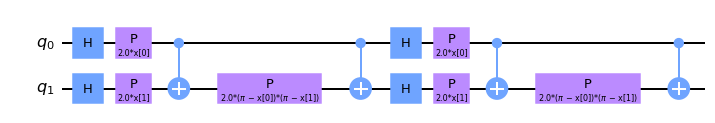

In [25]:
feature_map = ZZFeatureMap(feature_dimension=nfeatures, reps=2, entanglement="linear")
feature_map.decompose().draw(output='mpl')

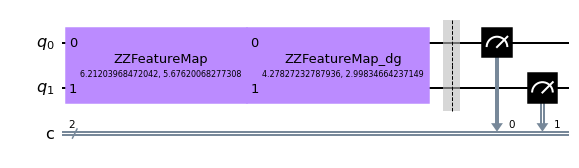

In [26]:
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
)
kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
circuit = kernel.construct_circuit(train_dataset.features[0], train_dataset.features[1])
circuit.decompose().draw(output='mpl')

In [27]:
svc = SVC(kernel=kernel.evaluate)
svc.fit(train_dataset.features, train_dataset.labels)
score = svc.score(test_dataset.features, test_dataset.labels)

print(f"Callable kernel classification test score: {score}")

Callable kernel classification test score: 0.4


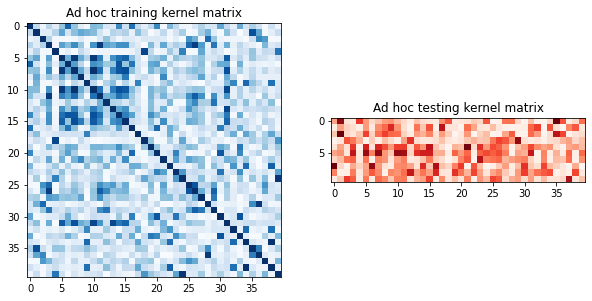

Precomputed kernel classification test score: 0.4


In [28]:
matrix_train = kernel.evaluate(x_vec=train_dataset.features)
matrix_test = kernel.evaluate(x_vec=test_dataset.features, y_vec=train_dataset.features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

svc = SVC(kernel="precomputed")
svc.fit(matrix_train, train_dataset.labels)
score = svc.score(matrix_test, test_dataset.labels)

print(f"Precomputed kernel classification test score: {score}")

In [31]:
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(train_dataset.features, train_dataset.labels)
qsvc_score = qsvc.score(test_dataset.features, test_dataset.labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.4
